In [299]:
import numpy as np
import matplotlib.pyplot as plt
import torch # for CIFAR
import torchvision
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
np.random.seed(0)

In [300]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# trainset = torchvision.datasets.CIFAR10(root='./Datasets', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./Datasets', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                         shuffle=False, num_workers=2)
iterator = iter(testloader)
images, labels = next(iterator)

Files already downloaded and verified


In [301]:
print(images.shape)
image = images[0].permute(1,2,0)

torch.Size([10000, 3, 32, 32])


In [302]:
batch = []
for label in range(10):
    pos = np.where(labels == label)
    top_3 = pos[0][:3]
    print(top_3)
    image_set = [images[i] for i in top_3]
    image_set = [image.permute(1,2,0) for image in image_set]
    batch += image_set

[ 3 10 21]
[ 6  9 37]
[25 35 65]
[ 0  8 46]
[22 26 32]
[12 16 24]
[4 5 7]
[13 17 20]
[ 1  2 15]
[11 14 23]


In [303]:
print(len(batch))

30


In [304]:
print(labels[0])

tensor(3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Normalized image')

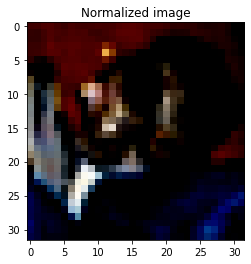

In [305]:
plt.imshow(image)
plt.title('Normalized image')

In [306]:
def sigmoid(input_space): # should work for both sheets and vectors
    return 1/(1 + np.exp(-input_space))

In [307]:
def convolve(sheet, kernel, stride = 1, padding = 2, activation = sigmoid):
    kernel_size = kernel.shape[0]
    output_image = np.zeros((int((sheet.shape[0] - kernel_size + 2*padding)/stride) + 1, int((sheet.shape[1] - kernel_size + 2*padding)/stride) + 1))
    sheet = np.pad(sheet, padding, 'constant')
    for i in range(output_image.shape[0]):
        for j in range(output_image.shape[1]):
            output_image[i, j] = np.sum(sheet[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size] * kernel)
            # print(output_image[i, j])
    return activation(output_image)

In [308]:
kernel = np.ones((3, 3))
op = convolve(np.ones((5, 5)), kernel, stride = 2, padding = 0)
print(np.ones((5, 5)))
print(kernel)
print(op.shape)
print(op)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
(2, 2)
[[0.99987661 0.99987661]
 [0.99987661 0.99987661]]


In [309]:
def convolve_image(image, kernel, stride, padding, activation = sigmoid):
    channels = image.shape[2]
    if(kernel.shape[2] != channels):
        print("Error: Kernel and Image not conformable")
        return
    else:
        output_size = int((image.shape[0] - kernel.shape[0] + 2*padding)/stride) + 1
        output_image = np.zeros((output_size, output_size))
        channel_sum = np.zeros_like(output_image)
        for i in range(channels):
            channel_sum += convolve(image[:, :, i], kernel[:, :, i], stride, padding, activation)
        output_image = channel_sum
        return output_image

In [310]:
def pool_image(image, kernel_size, stride=1, padding=0, option = "max"):
    if(option == "max"):
        output_size = int((image.shape[0] - kernel_size + 2*padding)/stride) + 1
        output_image = np.zeros((output_size, output_size))
        for i in range(output_image.shape[0]):
            for j in range(output_image.shape[1]):
                output_image[i, j] = np.max(image[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size])
        return output_image
    elif(option == "avg"):
        output_size = int((image.shape[0] - kernel_size + 2*padding)/stride) + 1
        output_image = np.zeros((output_size, output_size))
        for i in range(output_image.shape[0]):
            for j in range(output_image.shape[1]):
                output_image[i, j] = np.mean(image[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size])
        return output_image
        
    

In [311]:
def GAP(input_volume, padding = 0):
    output_volume = np.zeros((1, 1, input_volume.shape[2]))
    for i in range(input_volume.shape[2]):
        output_volume[0, 0, i] = np.mean(input_volume[:, :, i])
    return output_volume

In [312]:
convolve_image(np.ones((5, 5, 3)), np.ones((3, 3, 3)), 1, 0)

array([[2.99962982, 2.99962982, 2.99962982],
       [2.99962982, 2.99962982, 2.99962982],
       [2.99962982, 2.99962982, 2.99962982]])

In [313]:
def conv2d(input_volume, out_channels, kernel_size, stride = 1, padding = 0, activation = sigmoid):
    in_shape= input_volume.shape[0]
    in_channels = input_volume.shape[2]
    kernels = np.random.randn(out_channels, kernel_size, kernel_size, in_channels)
    output_size = int((in_shape - kernel_size + 2*padding)/stride) + 1
    output_volume = np.zeros((output_size, output_size, out_channels))
    # print(output_volume.shape)
    for i in range(out_channels):
        output_volume[:,:,i] = convolve_image(input_volume, kernels[i], stride, padding, activation)
    return (output_volume)

In [314]:
conv2d(np.ones((5, 5, 3)), 7, 3, 1, 0)

array([[[2.07919027, 0.90913285, 0.27690932, 2.15675731, 2.76083355,
         1.37175937, 0.5580917 ],
        [2.07919027, 0.90913285, 0.27690932, 2.15675731, 2.76083355,
         1.37175937, 0.5580917 ],
        [2.07919027, 0.90913285, 0.27690932, 2.15675731, 2.76083355,
         1.37175937, 0.5580917 ]],

       [[2.07919027, 0.90913285, 0.27690932, 2.15675731, 2.76083355,
         1.37175937, 0.5580917 ],
        [2.07919027, 0.90913285, 0.27690932, 2.15675731, 2.76083355,
         1.37175937, 0.5580917 ],
        [2.07919027, 0.90913285, 0.27690932, 2.15675731, 2.76083355,
         1.37175937, 0.5580917 ]],

       [[2.07919027, 0.90913285, 0.27690932, 2.15675731, 2.76083355,
         1.37175937, 0.5580917 ],
        [2.07919027, 0.90913285, 0.27690932, 2.15675731, 2.76083355,
         1.37175937, 0.5580917 ],
        [2.07919027, 0.90913285, 0.27690932, 2.15675731, 2.76083355,
         1.37175937, 0.5580917 ]]])

In [315]:
def pool2d(input_volume, kernel_size, stride, padding, mode = "avg"):
    input_channels = input_volume.shape[2]
    if(mode == "avg"):
        output_size = int((input_volume.shape[0] - kernel_size + 2*padding)/stride) + 1
        output_volume = np.zeros((output_size, output_size, input_channels))
        for i in range(input_channels):
            output_volume[:, :, i] = pool_image(input_volume[:, :, i], kernel_size, stride, padding, "avg")
    elif(mode == "max"):
        output_size = int((input_volume.shape[0] - kernel_size + 2*padding)/stride) + 1
        output_volume = np.zeros((output_size, output_size, input_channels))
        for i in range(input_channels):
            output_volume[:, :, i] = pool_image(input_volume[:, :, i], kernel_size, stride, padding, "max")
    else:
        output_volume = GAP(input_volume, padding) 
    return output_volume

In [316]:
def softmax(x):
    x = x - np.max(x, axis = 0, keepdims=True) # for numerical statbility of the softmax function
    return np.exp(x)/np.sum(np.exp(x), axis = 0)

In [317]:
def tanh(input_vector):
    return np.tanh(input_vector)

In [318]:
x = np.random.randn(5, 5, 3)
pool2d(x, 3, 1, 0, "GAP")

array([[[-0.14707542, -0.03463301, -0.04837921]]])

In [319]:
def flatten(input_volume):
    return input_volume.reshape((input_volume.shape[0]*input_volume.shape[1]*input_volume.shape[2], 1))

In [320]:
def MLP(input_vector, sizes, activation=sigmoid):
    sizes = [input_vector.shape[0]] + sizes
    output = input_vector
    # print(len(sizes))
    weights = [np.random.randn(sizes[i+1], sizes[i]) for i in range(len(sizes) - 1)]
    biases = [np.random.randn(sizes[i+1], 1) for i in range(len(sizes) - 1)]
    for i in range(len(sizes) - 1):
        output = activation(np.dot(weights[i],output) + biases[i])
    return output

In [321]:
input_vector = np.random.randn(5, 1)
sizes = [5, 6, 7, 2]
MLP(input_vector, sizes)

array([[0.76645481],
       [0.7917724 ]])

In [322]:
class ConvolutionalNet:
    def __init__(self):
        self.input = None
        self.output = None
        self.bottle_neck = None
    def forward(self, x_in):
        self.input = x_in
        x = x_in
        x = conv2d(x, 16, 3, 1, 0, sigmoid)
        x = pool2d(x, 2, 2, 0, "max")
        x = conv2d(x, 8, 3, 1, 0, sigmoid)
        x = pool2d(x, 2, 2, 0, "max")
        x = GAP(x, 0)
        x = flatten(x)
        self.bottle_neck = x
        x = MLP(x, [x.shape[0], 10], sigmoid)
        x = softmax(x)
        self.output = x
        return x
    def get_bottle_neck(self):
        return self.bottle_neck

In [323]:
net = ConvolutionalNet()

In [324]:
x = net.forward(image)
print(x.shape)

(10, 1)


In [325]:
bottlenecks = np.zeros((len(batch), net.get_bottle_neck().shape[0]))
outputs =  []
pred_labels = []
i = 0
for image in batch:
    op = net.forward(image)
    bn = net.get_bottle_neck()
    pred_label = np.argmax(op, axis = 0)
    pred_labels.append(pred_label)
    bottlenecks[i, :] = bn.reshape((bn.shape[0],))
    outputs.append(op)
    i = i + 1

In [326]:
print(bottlenecks.shape)

(30, 8)


In [327]:
pca = PCA(n_components=2)
Embeddings = pca.fit_transform(bottlenecks)

In [328]:
print(Embeddings.shape)

(30, 2)


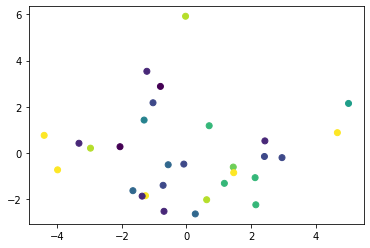

In [329]:
plt.scatter(Embeddings[:, 0], Embeddings[:, 1], c = pred_labels)